This is a plotting notebook. It analyzes data generated by `split_2_retrospective_perf_runs_for_main_text.ipynb`. Please refer to that notebook for details about the retrospective performance analysis that went into Supp Figures 1 and 2.

In [1]:
!pip install --upgrade pip
!pip install matplotlib==3.0.3

DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.
  Using cached pip-20.3.4-py2.py3-none-any.whl (1.5 MB)
  Using cached pip-20.3.3-py2.py3-none-any.whl (1.5 MB)
DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.


In [2]:
import os
import sys
import glob
import pickle
import random

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import policy_evaluation

sys.path.append('../common/')
import data_io_utils
import paths
import utils
import constants
import plot_style_utils


import A003_common

%reload_ext autoreload
%autoreload 2

In [3]:
print(paths.POLICY_EVAL_SPLIT_2_DIR)
data_io_utils.sync_s3_path_to_local(paths.POLICY_EVAL_SPLIT_2_DIR)

/notebooks/analysis/common/../../data/s3/policy_evaluation/split_2


## CONFIG

In [4]:
TRAINING_SET = 'sarkisyan'
ACQ_POLICY = 'RandomAcquisition'
SPLIT = 2
N_TEST = 96
N_TEST_IDX = np.argwhere(policy_evaluation.N_TESTING_POINTS_SCHEDULE == N_TEST).reshape(-1)[0]
STAT = 'recall_vs_n'

EXPECTED_N_REPS = 20

In [5]:
def load_gather_replicate_dfs(split, training_set, model, acq_policy):
    reps_dir = os.path.join(paths.POLICY_EVAL_DIR, 'split_' + str(split), 'train_'+training_set, model, acq_policy)
        
    rep_dirs = glob.glob(os.path.join(reps_dir, 'rep_*'))
    dfs = []
    for rd in rep_dirs:
        df_list = glob.glob(os.path.join(rd,'*.pkl'))
        assert len(df_list) == 1
        
        rep_num = int(os.path.basename(rd).split('_')[1])
        
        #print('Reading:', df_list[0])
        
        df = pd.read_pickle(df_list[0])
        df['rep'] = rep_num
        dfs.append(df)
        
    return pd.concat(dfs, 0)

def neigh_gen_df(df, neigh, gen_set):
    neigh_df = df.loc[neigh]
    return neigh_df[neigh_df['gen_set_name'] == gen_set]

In [6]:
representations = ['Full AA', 'Doc2Vec', 'UniRep', 'Local UniRep', 'eUniRep 1', 'eUniRep 2']
top_models = ['Lasso-Lars', 'Ridge', 'Ridge SR', 'Ens Ridge SR']

def generate_internal_model_name(rep, tm):    
    tm_dict = {
        'Lasso-Lars': 'LassoLarsModel%s',
        'Ridge': 'RidgeModel%s',
        'Ridge SR': 'RidgeModel%s_sparse_refit',
        'Ens Ridge SR': 'EnsembledRidgeModel%s_sparse_refit'
    }
    
    if rep == 'Doc2Vec':
        mn = rep + tm_dict[tm] % ''
    elif rep == 'Full AA':
        mn = tm_dict[tm] % ''
    elif rep == 'UniRep':
        mn = 'UniRep' + tm_dict[tm] % '_global'
    elif rep == 'Local UniRep':
        mn = 'UniRep' + tm_dict[tm] % '_et_random_init_1'
    elif rep == 'eUniRep 1':
        mn = 'UniRep' + tm_dict[tm] % '_et_global_init_1'
    elif rep == 'eUniRep 2':
        mn = 'UniRep' + tm_dict[tm] % '_et_global_init_2'
        
    return mn

In [7]:
def get_normalized_stat_vals_for_rep_and_top_model(rep, tm, n_train, gen_set):
    rep_df = load_gather_replicate_dfs(SPLIT, TRAINING_SET, generate_internal_model_name(rep, tm), ACQ_POLICY)

    ng_df = neigh_gen_df(rep_df, gen_set, 'combined_simple')
    ng_df = ng_df[ng_df['n_train'] == n_train]

    assert ng_df.shape[0] == EXPECTED_N_REPS

    stat_mat = np.vstack(ng_df[STAT]) # Reps x n-testing-points-schedule
    random_stat_mat = np.vstack(ng_df['random_' + STAT]) # Reps x n-testing-points-schedule

    norm_stat = stat_mat[:, N_TEST_IDX]/random_stat_mat[:,N_TEST_IDX] + 1/EXPECTED_N_REPS
    
    return norm_stat


def generate_stat_df(rep, n_train):
    norm_stats = []
    mname = []
    gsname = []
    for tm in top_models:
        for gs in ['simple_syn_neigh', 'simple_fp_homologs']:
            ns = get_normalized_stat_vals_for_rep_and_top_model(rep, tm, n_train, gs)

            norm_stats += list(ns)
            mname += [tm]*len(ns)
            gsname += [gs]*len(ns)

    stat_df = pd.DataFrame()
    stat_df['norm_stat'] = norm_stats
    stat_df['top_model'] = mname
    stat_df['gen_set'] = gsname
    
    return stat_df

def plot_stat_df(ax, stat_df):
    plot_style_utils.prettify_ax(ax)

    sns.boxplot(x='top_model', y='norm_stat', hue='gen_set', data=stat_df, 
                dodge=True, palette='colorblind', linewidth=2, fliersize=0, ax=ax)
    #sns.stripplot(x='top_model', y='norm_stat', hue='gen_set', data=stat_df, dodge=True, color='k', size=3, alpha=0.5, ax=ax)
    ax.set_yscale('log')
    ax.get_legend().remove()
    ax.set_ylim([1/EXPECTED_N_REPS-0.01, 100])
    ax.axhline(1, color='r', linestyle='--')

In [8]:
stat_df_dict = {}
for n_train in [8, 24, 96]:
    stat_dfs = []
    for rep in representations:
        print(rep)
        stat_dfs.append(generate_stat_df(rep, n_train))
        
    stat_df_dict[n_train] = stat_dfs

Full AA
Doc2Vec
UniRep
Local UniRep
eUniRep 1
eUniRep 2
Full AA
Doc2Vec
UniRep
Local UniRep
eUniRep 1
eUniRep 2
Full AA
Doc2Vec
UniRep
Local UniRep
eUniRep 1
eUniRep 2


In [9]:
def plot_stat_df_collection(stat_dfs):
    plot_style_utils.set_pub_plot_context()
    fig = plt.figure(figsize=(len(representations)*2.5,4))
    gs = fig.add_gridspec(1,len(representations))

    axes = []
    for i,rep in enumerate(representations):
        ax = fig.add_subplot(gs[0,i])
        plot_stat_df(ax, stat_dfs[i])
        ax.grid('on')
        ax.set_xlabel(None)
        ax.set_ylabel(None)

        if rep == 'Local UniRep':
            ax.set_title('Local UniRep', fontsize=22)
        else:
            ax.set_title(rep, fontsize=22)

        for tick in ax.get_xticklabels():
            tick.set_rotation(90)
            tick.set_fontsize(20)

        if i != 0:
            ax.set_yticklabels([])
            ax.set_ylabel(None)

        axes.append(ax)

    plt.show()
    return fig

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


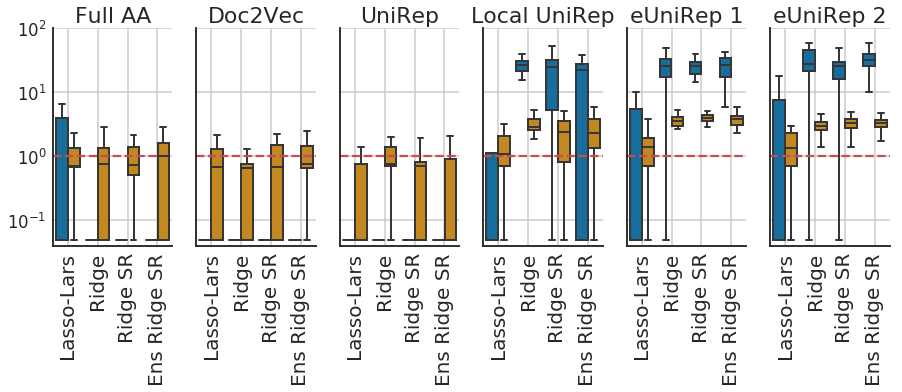

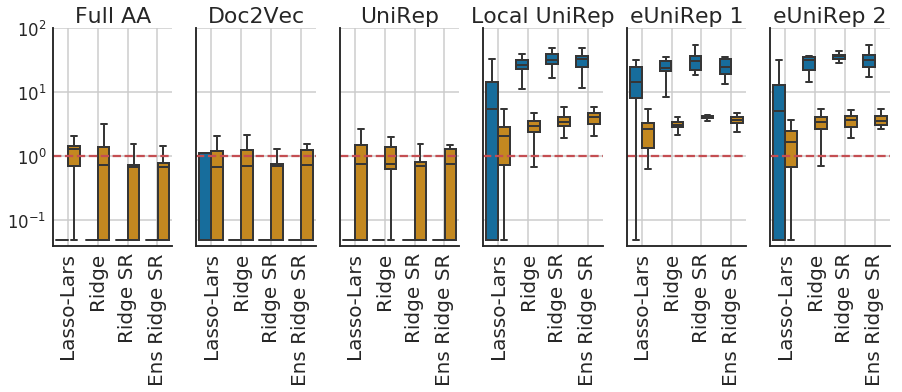

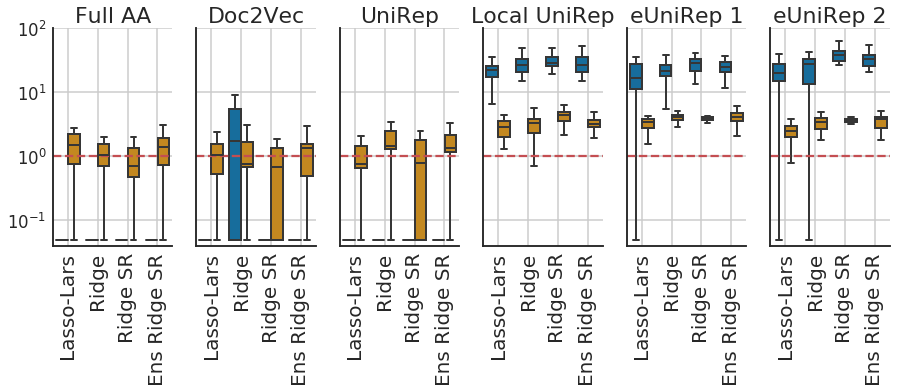

In [10]:
for n_train in [8, 24, 96]:
    fig = plot_stat_df_collection(stat_df_dict[n_train])
    plot_style_utils.save_for_pub(fig, 
            path="figures/retrospective_perf_N-train-%s_N-test-%s" % (str(n_train), str(N_TEST)), 
            dpi=300, include_vector=True)